# Time Based Analysis

This note book will host analysis for the time-based features for the Poland Car Ads Dataset

**In order to smooth run of this notebook, make sure you have csv for the car dataset stored in the same folder as this notebook in your repo.**

## Library & Import

In [16]:
#### supress warnings ####
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


#### Remove Scientic Notation While Displaying Pandas Data
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
car_sales_df = pd.read_csv('Car_sale_ads.csv') #### Read csv as dataframe & drop index column
car_sales_df.head(3) 

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.000,...,Manual,small_cars,3.000,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.000,...,Manual,coupe,2.000,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.000,...,Automatic,small_cars,3.000,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."


## Basic Data Check

First, we will do basic EDA & Null Check

In [3]:
car_sales_df.isnull().sum()

Index                           0
Price                           0
Currency                        0
Condition                       0
Vehicle_brand                   0
Vehicle_model                   0
Vehicle_version             70222
Vehicle_generation          60444
Production_year                 0
Mileage_km                    983
Power_HP                      643
Displacement_cm3             1966
Fuel_type                       0
CO2_emissions              114257
Drive                       15076
Transmission                  479
Type                            0
Doors_number                 1487
Colour                          0
Origin_country              89992
First_owner                143210
First_registration_date    121859
Offer_publication_date          0
Offer_location                  0
Features                        0
dtype: int64

The dataframe has 3 time-based columns & apart first registration date has around 60% of its data missing. For doing time series analysis we would choose one time based column & perform the trend analysis.

Let's see data types

In [4]:
car_sales_df.dtypes

Index                        int64
Price                        int64
Currency                    object
Condition                   object
Vehicle_brand               object
Vehicle_model               object
Vehicle_version             object
Vehicle_generation          object
Production_year              int64
Mileage_km                 float64
Power_HP                   float64
Displacement_cm3           float64
Fuel_type                   object
CO2_emissions              float64
Drive                       object
Transmission                object
Type                        object
Doors_number               float64
Colour                      object
Origin_country              object
First_owner                 object
First_registration_date     object
Offer_publication_date      object
Offer_location              object
Features                    object
dtype: object

The time features are not in date-time format. We would need to convert them in respective format

## Data Pre-Processing

In order to do the time analysis, first we would need to convert time columns to date-time format. Additionally, we will have to engineer additional set of features from the dates to get the granularity on the month, day, weekday level.

The production year column is less valuable here since it does not provide day & month information. Hence we will not use it to do the trend analysis.

In [5]:
#### Convert to datetime 
car_sales_df['First_registration_date'] = pd.to_datetime(car_sales_df['First_registration_date'], format='%d/%m/%Y',errors='coerce')
car_sales_df['Offer_publication_date'] = pd.to_datetime(car_sales_df['Offer_publication_date'], format='%d/%m/%Y',errors='coerce')

In [6]:
car_sales_df['Offer_publication_date'].min(), car_sales_df["Offer_publication_date"].max()

(Timestamp('2021-03-26 00:00:00'), Timestamp('2021-05-05 00:00:00'))

**As we can see, the first Ad post date is in last week of March 2021 & last Ad post date is First week of May 2024**

Let's engineer addtional features from the Publication Date

In [7]:
# Create new time-based features (e.g., Year, Month, Weekday, etc.)
car_sales_df['Publication_year'] = car_sales_df['Offer_publication_date'].dt.year
car_sales_df['Publication_month'] = car_sales_df['Offer_publication_date'].dt.month
car_sales_df['Publication_day'] = car_sales_df['Offer_publication_date'].dt.day
car_sales_df['Publication_weekdayr'] = car_sales_df['Offer_publication_date'].dt.weekday
car_sales_df['Publication_quarter'] = car_sales_df['Offer_publication_date'].dt.quarter

# Set 'Offer Publication Date' as the index for time-series analysis
car_sales_df.set_index('Offer_publication_date', inplace=True)

**We would not choose registration date as main focus of this analysis since more than 50% of it's data is missing. Even if we impute it, there would biases & anomalies in the imputed data as we saw in part 2 of our analysis**

**Hypothesis:**

We will carry this analysis on Ad Publication Dates as main focus. Let's assume the Ad Website went live in last week of March 2021 & we are doing this analysis to predict future trend sitting in May 2021

## EDA - Trends

Now, based on the time features derived from the Publication Date, let's so some EDA

In [8]:
# Resample the data by day, week, or month (depending on the granularity you want)
daily_counts = car_sales_df.resample('D').size()  # Daily count of ads
weekly_counts = car_sales_df.resample('W').size()  # Weekly count of ads
monthly_counts = car_sales_df.resample('M').size()  # Monthly count of ads

print('Total Uniq Daily Observations:',len(daily_counts))
print('Total Uniq Weekly Observations:',len(weekly_counts))
print('Total Uniq Monthly Observations:',len(monthly_counts))

Total Uniq Daily Observations: 41
Total Uniq Weekly Observations: 7
Total Uniq Monthly Observations: 3


As we can see, we have really less data to work with here. We will dedicate rest of the analysis based on daily trends

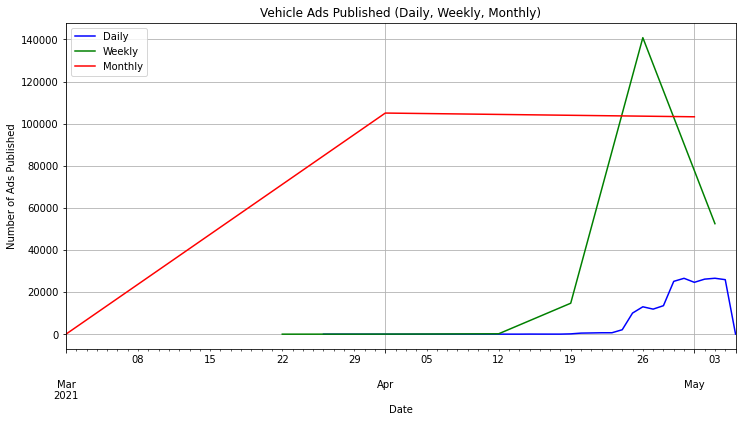

In [9]:
# Plot the daily, weekly, and monthly counts
plt.figure(figsize=(12, 6))
daily_counts.plot(label="Daily", color='blue')
weekly_counts.plot(label="Weekly", color='green')
monthly_counts.plot(label="Monthly", color='red')
plt.title("Vehicle Ads Published (Daily, Weekly, Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Ads Published")
plt.legend()
plt.grid(True)
plt.show()

We can see that, there's rising trend for the number of Ad posted on the website from March to May. This makes sense since when the website is new, the ads are less and as it becomes more popular, the ads grow.

Let's focus on daily trend and see how it looks like & spot if there are any anomalies

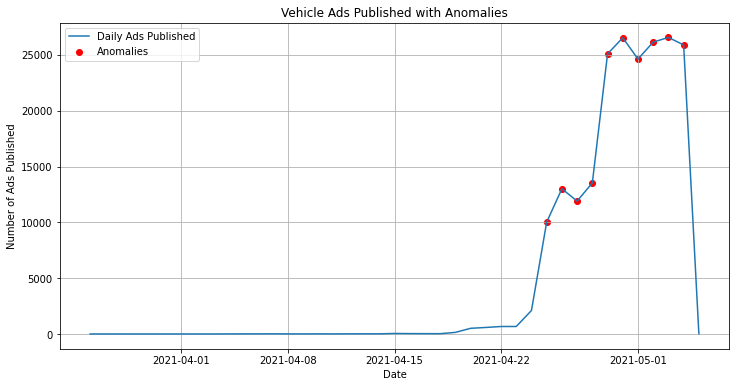

In [10]:
# Check for anomalies (simple visualization of anomalies for now)
# We will use the IQR method for anomaly detection.
Q1 = daily_counts.quantile(0.25)
Q3 = daily_counts.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily_counts[(daily_counts < lower_bound) | (daily_counts > upper_bound)]

#Plot with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(daily_counts, label="Daily Ads Published")
plt.scatter(outliers.index, outliers.values, color='red', label="Anomalies")
plt.title("Vehicle Ads Published with Anomalies")
plt.xlabel("Date")
plt.ylabel("Number of Ads Published")
plt.legend()
plt.grid(True)
plt.show()


As we can see, the traffic on the website shot exponetially in April, from the model point of view, it makes sense that it plotted it as anomalies. In May, there is sudden decline in traffic. It might makes senes since only have data for first 5 days from May.

## Time Series Analysis

Now we will do deep dive into the daily trends & do analysis. First we will do series decomposition to spot the seasonal trends & anomalies. Here we will choose 7 as the period since our data is on daily level.This will help us to undetand if we have any weekly trends

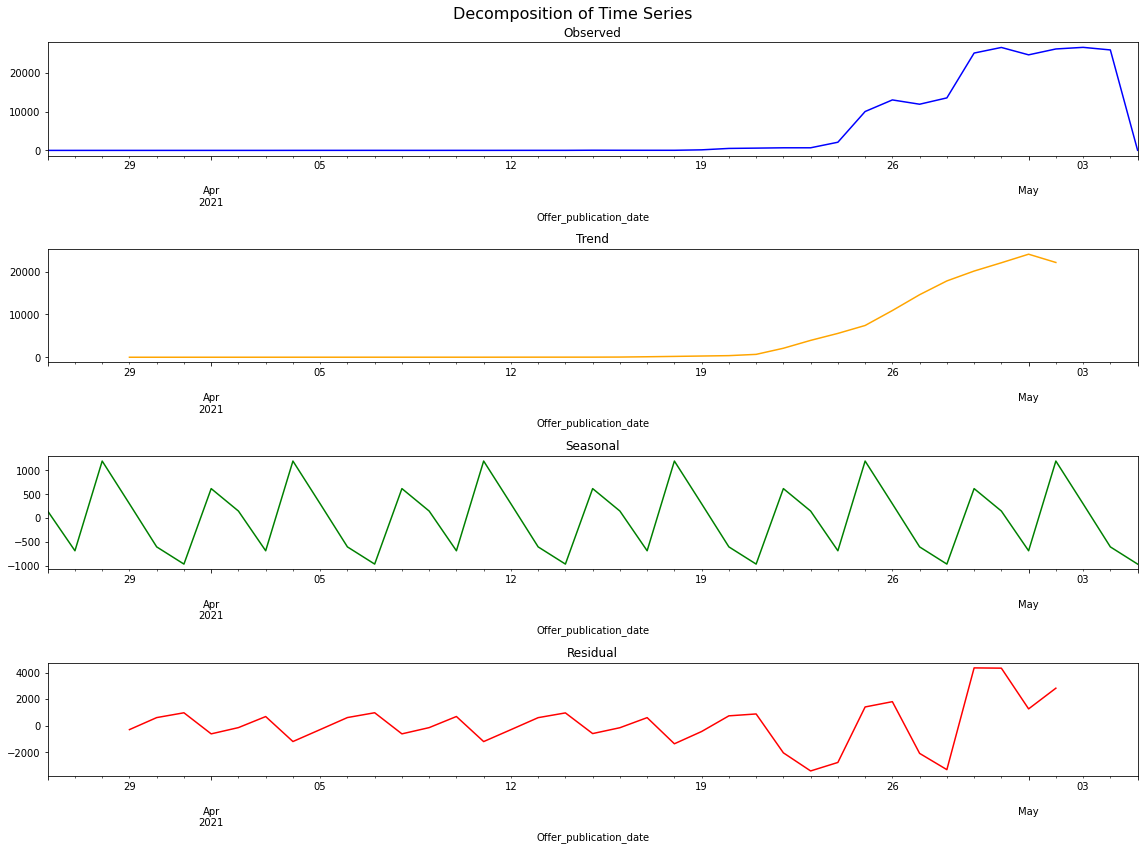

In [12]:
# Decompose the time series (daily counts)
result = seasonal_decompose(daily_counts, model='additive', period=7)  # Period 7 for daily seasonality


# Create subplots to display components manually
fig, axes = plt.subplots(4, 1, figsize=(16, 12))  # 4 rows for the components
fig.suptitle('Decomposition of Time Series', fontsize=16)

# Plot each component
result.observed.plot(ax=axes[0], title='Observed', color='blue')
result.trend.plot(ax=axes[1], title='Trend', color='orange')
result.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
result.resid.plot(ax=axes[3], title='Residual', color='red')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

**Observed:**
The observed component is the base graph we plotted earlier.

**Trend:** The trend component is increasing steadily over the period of time.
There is exponential growth observed, especially in late April, which could indicate a high-growth period. This could be seasonal factor or increasing popularity of the website

**Seasonal:**
We see cyclical pattern here with repeat at regular intervals, roughly every 7 days. These repeatations are positive as well as negative. The positives indicates actual values were more that expected while negative indicates opposite. The seasonal fluctuations seem to follow a repeating cycle of approximately 7 days. This hints that data might have a weekly seasonality. This might be explained if there's loads of ads posted every weekend on the website or something similar.

**Residuals:**
Positive residuals indicate that the actual values are higher than what the trend and seasonal components would suggest.
Negative residuals indicate that the actual values are lower than expected based on the trend and seasonal components. The residuals show irregular behavior, with no obvious pattern or cycle. This suggests that while trend and seasonality have been accounted for, there is still significant unexplained variability in the data.

Now we will do autocorrelation analysis

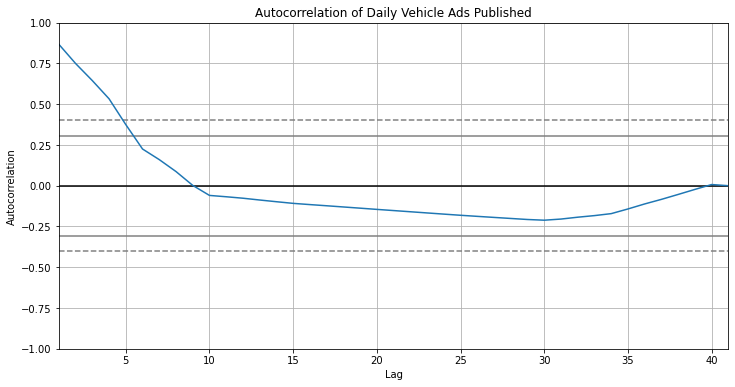

In [14]:
# Autocorrelation plot for the daily counts
plt.figure(figsize=(12, 6))
autocorrelation_plot(daily_counts)
plt.title("Autocorrelation of Daily Vehicle Ads Published")
plt.show()

From the graph above, we see that for lags <= 5, there's stong positive correlation value (~1). This indicates strong relationship between the current value and the previous day's value. We can say that the number of ads posted on one day is heavily influenced by the number posted the previous day. This effect of day 1 might persists for next 3-4 days.

After lag 9, there’s a gradual decline in the autocorrelation. This indicates weak or almost negligible influence between the current and values from significant past. This suggests that the ads posted beyond a few days might be less predictable from past behavior.

Between 10-30, there's steady decline with negative correlation. This suggest converse relationship where the ads posted on a given day are negatively correlated with those posted several days prior. This might hint as the weekly seasonality.

## Modelling

From this basic analysis, we see that the number of ads posted 1-2 days prior to current day have effect on next day. We can create basic model to predict next day ad traffic. Since we only have 41 data points, we cannot use deep learning models or statistical models like ARIMA that require large datasets.

We will use random forest with defaults since this is just proto-type & we have scaricity of data

In [17]:
daily_counts_df = daily_counts.reset_index(name='ad_count')

# Create lag features (for example, use past 1 and 2 days for prediction)
daily_counts_df['lag_1'] = daily_counts_df['ad_count'].shift(1)
daily_counts_df['lag_2'] = daily_counts_df['ad_count'].shift(2)

# Drop NaN values after creating lag features
daily_counts_df = daily_counts_df.dropna()

# Prepare data for modeling
X = daily_counts_df[['lag_1', 'lag_2']]
y = daily_counts_df['ad_count']

# Train the Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Make predictions for the next day (use the last available row in X)
last_row = X.iloc[-1].values.reshape(1, -1)

# Store the predicted values for the next 7 days
predicted_values = []

# Make predictions for the next 7 days
for i in range(7):
    # Predict the next day
    next_day_pred = model.predict(last_row)
    predicted_values.append(next_day_pred[0])
    
    # Update the last row with the new prediction as 'lag_1', and shift the previous values
    new_lag_1 = next_day_pred[0]
    new_lag_2 = last_row[0][0]  # Corrected indexing for the previous lag_1 value
    
    # Update the last_row for the next day's prediction
    last_row = [[new_lag_1, new_lag_2]]  # Keep it a list of lists

# Create a DataFrame with the predicted values for the next 7 days
# Use the last date from the index and add the next 7 days
predicted_dates = pd.date_range(start=daily_counts_df['Offer_publication_date'].max() + pd.Timedelta(days=1), periods=7, freq='D')
predictions_df = pd.DataFrame({'date': predicted_dates, 'predicted_ad_count': predicted_values})

# Display the predictions
print(predictions_df)

        date  predicted_ad_count
0 2021-05-06           10435.000
1 2021-05-07           15144.090
2 2021-05-08           19762.710
3 2021-05-09           24442.750
4 2021-05-10           24756.720
5 2021-05-11           23846.960
6 2021-05-12           23846.960


Now let's plot our predictions

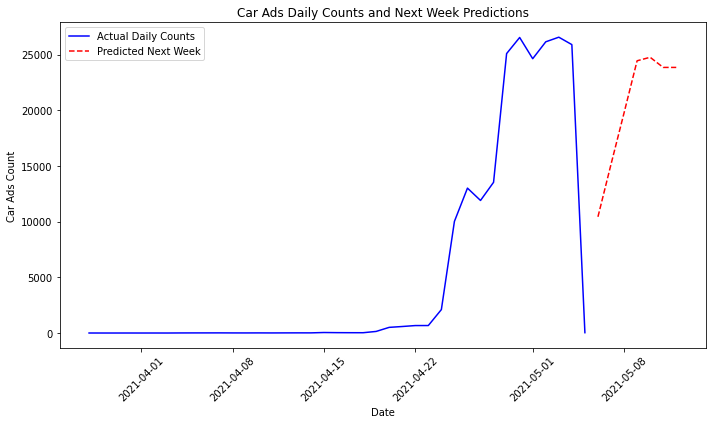

In [18]:
# Plot the results: Actual vs Predicted
plt.figure(figsize=(10, 6))

# Plot actual daily counts (ensure the index has datetime format)
plt.plot(daily_counts_df['Offer_publication_date'], daily_counts_df['ad_count'], label='Actual Daily Counts', color='blue')

# Plot predicted daily counts for the next week
plt.plot(predictions_df['date'], predictions_df['predicted_ad_count'], label='Predicted Next Week', color='red', linestyle='--')

# Adding titles and labels
plt.title("Car Ads Daily Counts and Next Week Predictions")
plt.xlabel("Date")
plt.ylabel("Car Ads Count")
plt.legend()

# Improve plot formatting
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Not bad considering less data we had. We can see the seasonal repeatiton of ads growing next week.

## Conclusion

The trend we saw in Ad postings would help business predict traffic on the website for the next coming days. If we have enough data points, we can do deeper dive & add features like car type, model & predict Ads for them in coming weeks. This would help with ad targeting for audiences. Based on fraud & anomalous ads we can create model that would predict any seasonal patterns in them.